<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 저혈압 예측 알고리즘

## 본 프로그램의 옵션들

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

MINUTES_AHEAD = 1  # 저혈압을 1분 전에 예측
LSTM_NODES = 16  # LSTM 내부의 셀 갯수
BATCH_SIZE = 256  # 한번에 처리할 레코드 수 (GPU 메모리 용량에 따라 결정)
MAX_CASES = 100  # 본 예제에서 사용할 최대 case 수

## Case Selection

In [ ]:
df_trks = pd.read_csv('https://api.vitaldb.net/v2/trks')  # 트랙 목록
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # 임상 정보

caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & \
    set(df_cases[df_cases['age'] > 18]['caseid']) & \
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # caseid를 무작위로 섞음

Total 3452 cases found


## 데이터셋 생성 및 전처리

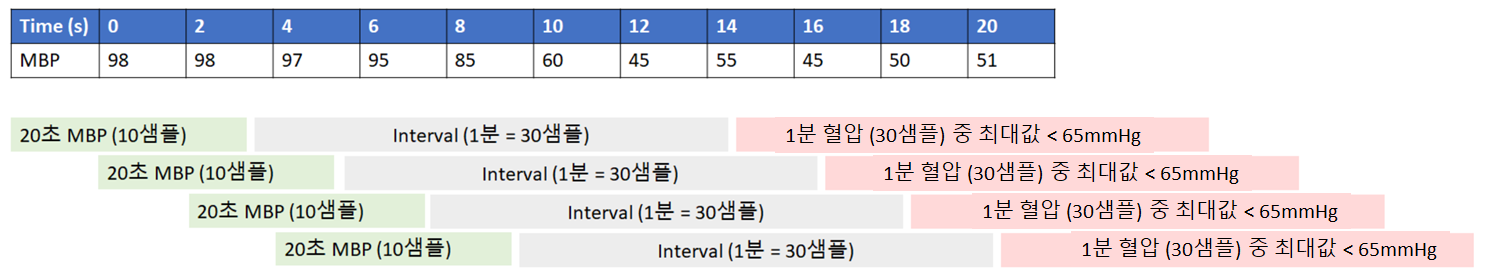

In [ ]:
def load_trk(tid, interval=1):
    try:
        url = 'https://api.vitaldb.net/' + tid
        dtmbps = pd.read_csv(url).values
    except:
        return np.empty(0)
    if len(dtmbps) == 0:
        return np.empty(0)
    dtmbps[:,0] /= interval  # convert time to row
    trklen = int(np.nanmax(dtmbps[:,0])) + 1  # find maximum index (array length)
    ret = np.full(trklen, np.nan)  # create a dense array
    for idx, val in dtmbps:  # copy values
        ret[int(idx)] = val
    return ret

# 최종 생성할 데이터셋
x = []  # 각 레코드의 혈압 시계열 데이터
y = []  # 각 레코드의 출력값 (3분 후 저혈압 발생 여부)
valid_mask = []  # 각 샘플이 유효한지 여부 (유효하지 않은 샘플도 그림을 그리기 위해 추출함)
y_caseid = []  # 각 레코드의 caseid

# 최대로 로딩할 case 수
ncase = min(MAX_CASES, len(caseids))
icase = 0
for caseid in caseids:
    print('loading {} ({}/{})...'.format(caseid, icase + 1, ncase), flush=True, end='')

    # 현 case의 ART_MBP 트랙을 로딩
    tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
    mbps = load_trk(tid, 2)  # 2초 인터벌

    # 2시간 이내의 case 들은 사용하지 않음
    if len(mbps) < 360:
        print('case len < 2h')
        continue

    # a-line 연결 전 샘플들을 제거
    with np.errstate(invalid='ignore'):
        mbps[mbps < 40] = np.nan

    # 처음과 마지막의 결측값을 제거
    case_valid_mask = ~np.isnan(mbps)
    mbps = mbps[(np.cumsum(case_valid_mask) != 0) & (np.cumsum(case_valid_mask[::-1])[::-1] != 0)]

    # 중간 결측값을 직전값으로 대체
    mbps = pd.DataFrame(mbps).fillna(method='ffill').values.flatten()
    
    # event data 뽑음
    case_sample = 0
    case_event = 0
    # 입력 혈압 (20초 = 10샘플)
    # 중간 윈도우 (MINUTES_AHEAD * 30 샘플)
    # 결과 혈압 (1분 = 30샘플)
    for i in range(len(mbps) - (10 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 10]

        # y는 mbp 기준
        segy = mbps[i + 10 + MINUTES_AHEAD * 30:i + 10 + MINUTES_AHEAD * 30 + 30]

        # 중간에 nan 있으면?
        valid = True
        if np.any(segx > 150):  # 어떤 샘플이든 150 이상이면?
            valid = False
        elif np.any(segy > 150):  # 어떤 샘플이든 150 이상이면?
            valid = False
        elif np.any(np.abs(np.diff(segx)) > 50):  # 2초만에 30 mmHg 이상 변하면
            valid = False
        elif np.any(np.abs(np.diff(segy)) > 50):  # 2초만에 30 mmHg 이상 변하면
            valid = False
        elif (segx < 40).all():  # 어떤 샘플이든 40 이하이면?
            valid = False
        elif (segy < 40).all():  # 어떤 샘플이든 40 이하이면?
            valid = False

        evt = np.nanmax(segy) < 65
        x.append(segx)  # 20초 segment
        y.append(evt)  # 최대 값이 65 미만이어야 함
        valid_mask.append(valid)
        y_caseid.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        icase += 1
        print("{} samples {} events ({:.1f}%)".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('all nan')

    if icase >= ncase:
        break

# 최종적으로 로딩 된 caseid
caseids = np.unique(y_caseid)

# 입력 데이터셋을 python array 에서 numpy array로 변경
x = np.array(x)[...,None]  # LSTM 에 입력으로 넣으려면 3차원으로 만들어야함
y = np.array(y) 
valid_mask = np.array(valid_mask)
y_caseid = np.array(y_caseid)

loading 2548 (1/100)...all nan
loading 3107 (1/100)...6594 samples 187 events (2.8%)
loading 5871 (2/100)...5163 samples 0 events (0.0%)
loading 1687 (3/100)...4847 samples 1 events (0.0%)
loading 5944 (4/100)...7641 samples 633 events (8.3%)
loading 1673 (5/100)...3601 samples 779 events (21.6%)
loading 2012 (6/100)...1174 samples 379 events (32.3%)
loading 3125 (7/100)...7299 samples 0 events (0.0%)
loading 774 (8/100)...9359 samples 987 events (10.5%)
loading 6330 (9/100)...4201 samples 41 events (1.0%)
loading 2462 (10/100)...7059 samples 35 events (0.5%)
loading 2845 (11/100)...5136 samples 0 events (0.0%)
loading 4137 (12/100)...7916 samples 6 events (0.1%)
loading 2712 (13/100)...4406 samples 613 events (13.9%)
loading 2680 (14/100)...6958 samples 759 events (10.9%)
loading 5292 (15/100)...2449 samples 52 events (2.1%)
loading 808 (16/100)...7049 samples 444 events (6.3%)
loading 439 (17/100)...4177 samples 79 events (1.9%)
loading 2595 (18/100)...6971 samples 0 events (0.0%)
lo

## Training / Testing set 으로 나눔

In [ ]:
# train, test set 을 case 단위로 나눔
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set과 test set 으로 나눔
train_mask = np.array([caseid in caseids_train for caseid in y_caseid])
test_mask = np.array([caseid in caseids_test for caseid in y_caseid])

# test set은 그림을 그려야 하므로 invalid 값까지 전체 데이터도 필요
test_x = x[test_mask]
test_y = y[test_mask]
test_y_caseid = y_caseid[test_mask]

# valid 한 값만 포함하는 배열 (학습 및 성능 평가시 사용)
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 1ahead batchsize=256 total 630146, train 475296 (20186 events 4.2%), test 120183 (6005 events 5.0%)'

## 모델 생성 및 학습 시작

In [ ]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# 임시 폴더를 생성
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# 최적의 모델을 저장
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
1669/1671 [============================>.] - ETA: 0s - loss: 0.2659 - accuracy: 0.9415 - auc: 0.9469
Epoch 00001: val_loss improved from inf to 0.15444, saving model to output/weights.hdf5
1671/1671 [==============================] - 10s 6ms/step - loss: 0.2658 - accuracy: 0.9415 - auc: 0.9469 - val_loss: 0.1544 - val_accuracy: 0.9429 - val_auc: 0.9700
Epoch 2/100
1668/1671 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9512 - auc: 0.9582
Epoch 00002: val_loss improved from 0.15444 to 0.10921, saving model to output/weights.hdf5
1671/1671 [==============================] - 10s 6ms/step - loss: 0.2206 - accuracy: 0.9512 - auc: 0.9582 - val_loss: 0.1092 - val_accuracy: 0.9545 - val_auc: 0.9704
Epoch 3/100
1663/1671 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9496 - auc: 0.9582
Epoch 00003: val_loss did not improve from 0.10921
1671/1671 [==============================] - 10s 6ms/step - loss: 0.2183 - accuracy: 0.9496 - auc:

2125

## 모델 성능 평가

In [ ]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# test을 한번에 예측
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# 최종 폴더명을 변경
odir = testname + ' ' + testres
os.rename(tempdir, odir)

auroc=0.954, auprc=0.488 acc=0.953, F1=0.441, PPV=55.0, NPV=96.7, TN=112363, fp=1815, fn=3790, TP=2215


## 그래프 그림

In [ ]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

# 각 case 그림
for caseid in caseids_test:
    case_mask = (y_caseid == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    # case 내의 x, y, valid_mask 를 만든다
    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # case 에러를 구하고 출력
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # 그림 생성
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # 저혈압 상태일 때를 붉은 반투명 배경으로
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg 가로선
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # valid 한 샘플만 그린다
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # 그림 저장
    plt.savefig('{}/{:.3f}_{}.png'.format(odir, case_rmse, caseid))
    plt.close()

5284	0.2533635869412729	
5292	0.13899401065775044	
5462	0.004232602589811871	
5490	0.1951201349900689	
5568	0.2012672753649524	
5572	0.16351170839994836	
5610	0.2840959091180007	
5678	0.09533921457560449	
5753	0.284343685270462	
5765	0.17167864767720956	
5831	0.21194318052726469	
5871	0.0007153860609217485	
5944	0.18633765310241648	
6104	0.10840770320984967	
6153	0.17462491535950658	
6192	0.07012890648734289	
6206	0.2434751443440634	
6259	0.13802457225581619	
6330	0.13473761308873922	
6385	0.24839586952778922	
